In [1]:
## SRJ

## Introducing shots to Adapt VQE

In [2]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqesri(adapt_it, e_th):
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits, shots = 100000)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                print('Exc. dealing right now is', ash_excitation[i])
                print('The params that are going in', params[i])
                qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
            elif len(ash_excitation[i]) == 2:
                print('Single Exc. dealing right now is', ash_excitation[i])
                print('Single exc params that are going in', params[i])
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]
    params = np.zeros(len(ash_excitation), requires_grad=True)
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        # Start with the most recent state (last state in the list)
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                print('Print, if this is activated - HF state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        print('The current status of ash_excitation is', ash_excitation)
        print('Moving towards parameters')
        params = np.append(params, 0.0)  #Parameters initialization
        print('The parameters are', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation




In [ ]:
adaptvqesri(adapt_it=5, e_th=1e-12)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.333117372313189
The adapt iteration now is 0
The current excitation operator is a⁺(0) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(4) is 0.0009121309918044844
The current excitation operator is a⁺(0) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(6) is 0.002189466714024063
The current excitation operator is a⁺(1) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(5) is 0.002366644772474611
The current excitation operator is a⁺(1) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(7) is 0.0010296348192514117
The current excitation operator is a⁺(2) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(4) is 0.0030840244955145065
The current excitation operator is a⁺(2) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(6) is 0.00219709016798467
The current excitation operato

([-1.4312595647624438,
  -1.5717093342683037,
  -1.7448249806345615,
  -1.8433718926100577,
  -1.8515930894603712],
 array([-0.85229076, -1.29324081, -1.04599279, -1.06727596,  0.28090486]),
 [[2, 3, 6, 7], [1, 2, 4, 7], [0, 1, 4, 5], [0, 3, 5, 6], [0, 4]])

In [11]:
import math
x = np.array([0.11758852766369]) 
y = 0.117323082420

E = x - y
print(E)
z = math.log(E)

print(z)

[0.00026545]
-8.234101977008093


/var/folders/tg/76l0rq6n6m3bzwcmn22dk8_59wwtc3/T/ipykernel_6489/534994966.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = math.log(E)


In [15]:
import math
x = np.array([0.4250287344342954]) 
y = 0.4138765129024483

E = x - y
print(E)
z = math.log(E)

print(z)

[0.01115222]
-4.496116560397365


/var/folders/tg/76l0rq6n6m3bzwcmn22dk8_59wwtc3/T/ipykernel_6489/4071417618.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = math.log(E)


## 100k shots - 5 parameters case

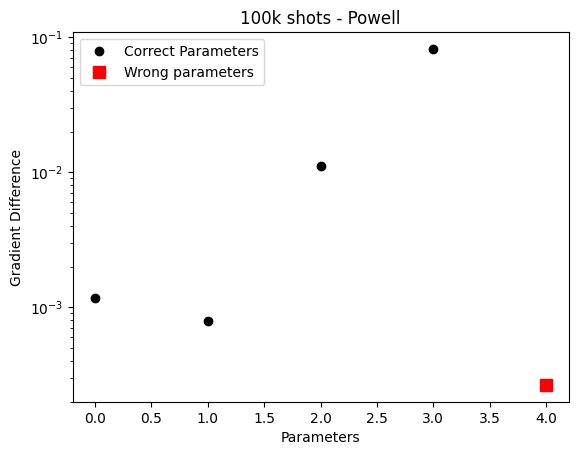

In [28]:
import matplotlib.pyplot as plt

Parameters = (0, 1, 2, 3, 4)
GD = (1.16002e-3, 7.8643e-4, 1.115222e-2, 0.08182, 2.6545e-4)

# Separate the last point
last_param = Parameters[-1]
last_gd = GD[-1]

# Plot all points except the last one
plt.plot(Parameters[:-1], GD[:-1], 'o',  color = 'black',label='Correct Parameters')

# Plot the last point with a different color and symbol
plt.plot(last_param, last_gd, 'rs', markersize=8, label='Wrong parameters')  # 'rx' for red 'x'

plt.xlabel('Parameters')
plt.ylabel('Gradient Difference')
plt.yscale('log')
plt.legend()
plt.title('100k shots - Powell')
plt.show()

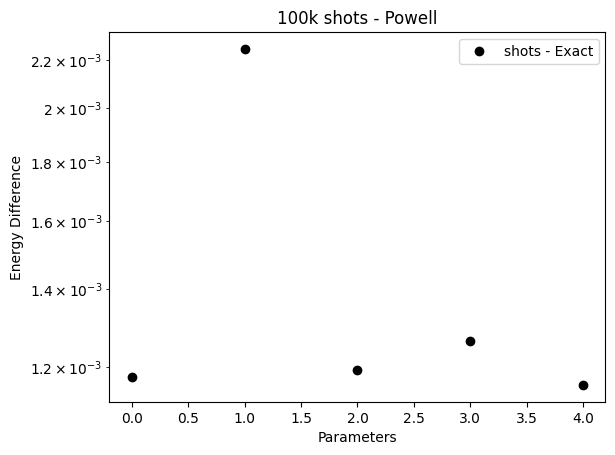

In [ ]:
ExactE = np.array([-1.4300836708403402,
  -1.5694603835520677,
  -1.7436334426149698,
  -1.8421101514362364,
  -1.8504359363275726])

shotsE = np.array([-1.4312595647624438, -1.5717093342683037, -1.7448249806345615, -1.8433718926100577, -1.8515930894603712])
Ediff = abs(shotsE - ExactE)

last_param = Parameters[-1]
last_gd = Ediff[-1]
import matplotlib.pyplot as plt
plt.plot(Parameters, Ediff, 'o', color = 'black',label = 'shots - Exact')
plt.xlabel('Parameters')
plt.ylabel('Energy Difference')
plt.yscale('log')
plt.legend()
plt.title('100k shots - Powell')
plt.show()


## 100k shots - 21 Parameters - Powell